In [191]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import toeplitz, circulant
from matplotlib import pyplot as plt
import config
import models
import tasks
import networks
import plots
import argparse
import json
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
import numpy as np
import pathlib
from sklearn.manifold import TSNE

In [192]:
noise_amplitude = 0.1 #*0
dim_recurrent = 100
simple_input = False
simple_output = True
hold_zero=False
redo_preanalysis = True # None = redo only if necessary

ORI_RES = 3

hold_orientation_for = 10
hold_cue_for = 100
delay0_set = torch.tensor([0]) 
delay0_set = torch.arange(30, 50)
delay1_set = torch.arange(30, 50)
delay2_set = torch.arange(30, 50)
delay0, delay1, delay2 = 40, 40, 40

total_time = hold_orientation_for*2+hold_cue_for+delay0+delay1+delay2
t1, t1d = -1+delay0 if delay0>0 else 0, "before O1 presented"
t1_5, t1_5d = -1+delay0+hold_orientation_for//2, "amid 01 presentation"
t2, t2d = -1+delay0+hold_orientation_for, "after O1 presented"
t3, t3d = -1+delay0+hold_orientation_for+delay1, "before O2 presented"
t3_5, t3_5d = -1+delay0+hold_orientation_for+delay1+hold_orientation_for//2, "amid O2 presentation"
t4, t4d = -1+delay0+hold_orientation_for+delay1+hold_orientation_for, "after O2 presented"
t5, t5d = -1+delay0+hold_orientation_for+delay1+hold_orientation_for+delay2, "before go cue"
t6, t6d = -1+total_time, "end of task"

orientation_neurons = 32
task = tasks.TWO_ORIENTATIONS_DOUBLE_OUTPUT(orientation_neurons, hold_orientation_for, hold_cue_for, delay0_set, delay1_set, delay2_set,
                                        simple_input=simple_input, simple_output=simple_output)
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")

In [351]:
def analyze_error(model, second_noise=False, noise_amplitude=0.0, ORI_RES = 3):
    ORI_SET = np.arange(0, 180, ORI_RES)
    ORI_SET_SIZE = ORI_SET.shape[0]
    def network_performance():
        error = torch.sum((megabatch_output[0][megabatch_mask == 1] - megabatch_target[megabatch_mask == 1]) ** 2, dim=0) / torch.sum(megabatch_mask == 1)
        MSE_O1 = (error[0]+error[1]).item()
        MSE_O2 = (error[2]+error[3]).item()
        trig = megabatch_output[0][:, t5+1:t6+1, :]
        o1 = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
        o2 = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
        trig = megabatch_target[:, t5+1:t6+1, :]
        o1_t = torch.atan2((trig[:, :, 0]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5), (trig[:, :, 1]/(trig[:, :, 0]**2+trig[:, :, 1]**2)**0.5)) / 2 * 180 / math.pi
        o2_t = torch.atan2((trig[:, :, 2]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5), (trig[:, :, 3]/(trig[:, :, 2]**2+trig[:, :, 3]**2)**0.5)) / 2 * 180 / math.pi
        error_o1 = torch.minimum(torch.minimum((o1-o1_t)**2, (o1-o1_t+180)**2), (o1-o1_t-180)**2)
        error_o1 = torch.mean(error_o1).item()**0.5
        error_o2 = torch.minimum(torch.minimum((o2-o2_t)**2, (o2-o2_t+180)**2), (o2-o2_t-180)**2)
        error_o2 = torch.mean(error_o2).item()**0.5
        return MSE_O1, MSE_O2, error_o1, error_o2
    def generate_megabatch(task, delay0, delay1, delay2):
        batch = []
        batch_labels = []
        output_masks = []
        for orientation1 in ORI_SET:
            for orientation2 in ORI_SET:
                to_batch, to_batch_labels, to_mask = task._make_trial(orientation1, orientation2, delay0, delay1, delay2)
                batch.append(to_batch.unsqueeze(0))
                batch_labels.append(to_batch_labels.unsqueeze(0))
                output_masks.append(to_mask.unsqueeze(0))
        return torch.cat(batch).to(config.device), torch.cat(batch_labels).to(config.device), torch.cat(
            output_masks).to(config.device)
    batch = generate_megabatch(task, delay0, delay1, delay2)
    print("Running the model...")
    #output = model(batch[0], noise_amplitude=noise_amplitude)
    t_bhneverlearn = noise_amplitude * torch.randn(model.get_noise_shape(batch[0]))
    bhneverlearn = torch.zeros(t_bhneverlearn.shape)
    t1 = delay0+hold_orientation_for+delay1+hold_orientation_for
    t2 = t1 + delay2
    if second_noise:
        bhneverlearn[:, t1:t2, :] = t_bhneverlearn[:, t1:t2, :]
    else:
        bhneverlearn = t_bhneverlearn
    output = model._forward(batch[0], bhneverlearn=bhneverlearn)
    megabatch_output = output
    megabatch_input, megabatch_target, megabatch_mask = batch
    
    A = megabatch_output[1][:, -hold_cue_for:, :].reshape((180//ORI_RES)**2*hold_cue_for, -1)[:, R1_i]
    P = torch.linalg.inv(A.T@A+20000*torch.eye(len(A.T@A)))@A.T
    #P[R2_i] = 0
    P_O1_S = P @ megabatch_target[:, -hold_cue_for:, 0].reshape(-1)
    P_O1_C = P @ megabatch_target[:, -hold_cue_for:, 1].reshape(-1)
    O1_E_S = torch.mean((A@P_O1_S - megabatch_target[:, t5:t6, 0].reshape(-1))**2)
    O1_E_C = torch.mean((A@P_O1_C - megabatch_target[:, t5:t6, 1].reshape(-1))**2)
    plt.plot(P_O1_S.detach().numpy())
    plt.show()
    A = megabatch_output[1][:, -hold_cue_for:, :].reshape((180//ORI_RES)**2*hold_cue_for, -1)[:, R2_i]
    P = torch.linalg.pinv(A)
    P_O2_S = P @ megabatch_target[:, -hold_cue_for:, 2].reshape(-1)
    P_O2_C = P @ megabatch_target[:, -hold_cue_for:, 3].reshape(-1)
    O2_E_S = torch.mean((A@P_O2_S - megabatch_target[:, t5:t6, 2].reshape(-1))**2)
    O2_E_C = torch.mean((A@P_O2_C - megabatch_target[:, t5:t6, 3].reshape(-1))**2)
    plt.plot(P_O2_S.detach().numpy())
    plt.show()
    
    
    
    print(torch.mean((megabatch_target[:, -hold_cue_for:, 0]-megabatch_output[0][:, -hold_cue_for:, 0])**2).item())
    print(torch.mean((megabatch_target[:, -hold_cue_for:, 1]-megabatch_output[0][:, -hold_cue_for:, 1])**2).item())
    print(torch.mean((megabatch_target[:, -hold_cue_for:, 1]-megabatch_output[0][:, -hold_cue_for:, 1])**2).item()+torch.mean((megabatch_target[:, -hold_cue_for:, 0]-megabatch_output[0][:, -hold_cue_for:, 0])**2).item())
    
    return network_performance(), O1_E_S+O1_E_C, O2_E_S+O2_E_C

Running the model...


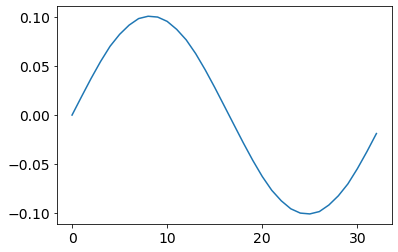

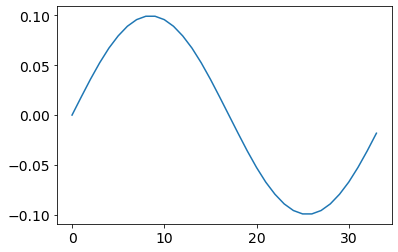

0.0010360253509134054
0.0010359942680224776
0.002072019618935883


((0.002072019735351205,
  0.0007905120146460831,
  0.977068899464225,
  0.7891760640523061),
 tensor(0.0111, grad_fn=<AddBackward0>),
 tensor(0.0107, grad_fn=<AddBackward0>))

In [352]:
analyze_error(model, ORI_RES=3)

In [ ]:
def weight(pref1, pref2):
    return 1 * ( torch.cos(2*(pref1-pref2)/180 * np.pi))
    a = 0.5
    return np.maximum(np.minimum(1+a-torch.abs(pref1-pref2)/90 * 2*(1+a), 1.), -1.)
def weight_ns(pref1, pref2):
    return 1
N = torch.arange(-90, 90, 1)

plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(4, 2))
plt.axhline(y = 0, color = 'r', linestyle = '--', linewidth=10)
plt.plot(N, weight(N, 0), linewidth=20, color="k")
plt.xlabel('Difference in pref. orientation (deg)', fontsize=16)
plt.ylabel('Conenction weight', fontsize=16)
plt.xticks([-90, -45, 0, 45, 90])
plt.ylim(-1.3, 1.3)
plt.show()

In [ ]:
def new_model():
    model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
    with torch.no_grad():
        model.fc_x2ah.weight[:, :] = 0
        model.fc_x2ah.bias[:] = 0
        model.fc_h2ah.weight[:, :] = 0
        model.fc_h2y.weight[:, :] = 0
        model.fc_h2y.bias[:] = 0
    return model
def save_model(model):
    torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")
def put_weights(model, units_from, units_to, units_from_pref=None, units_to_pref=None, weight_fun=weight, m=None, m_s=None):
    if type(units_from) is str: units_from = units_from.upper()
    
    uf_N = orientation_neurons if units_from=="IN" else len(units_from)
    ut_N = len(units_to)
    if m_s is not None: m = m_s / uf_N / ut_N
    if m is None: m = 1
    magnitude = m
    if units_from_pref is None:
        units_from_pref = torch.arange(uf_N) * 180 / uf_N
    if units_to_pref is None:
        units_to_pref = torch.arange(ut_N) * 180 / ut_N
    
    if units_from == "IN":
        units_from = torch.arange(orientation_neurons)
        for i, uf in enumerate(units_from):
            for j, ut in enumerate(units_to):
                with torch.no_grad():
                    model.fc_x2ah.weight[ut, uf] = weight_fun(units_from_pref[i], units_to_pref[j]) * magnitude
    else:
        for i, uf in enumerate(units_from):
            for j, ut in enumerate(units_to):
                with torch.no_grad():
                    model.fc_h2ah.weight[ut, uf] = weight_fun(units_from_pref[i], units_to_pref[j]) * magnitude
def put_bias(model, units_to, m=None, m_s=None):
    ut_N = len(units_to)
    if m_s is not None: m = m_s / 32 / ut_N
    if m is None: m = 1
    magnitude = m
    with torch.no_grad():
        model.fc_x2ah.bias[units_to] = magnitude

## R1 stronger than R2

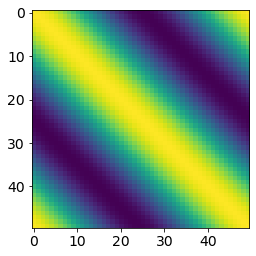

In [175]:
R1_N = 50
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 50
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j])
plt.imshow(R1_W)
R1_i = range(50)
R2_i = range(50, 100)

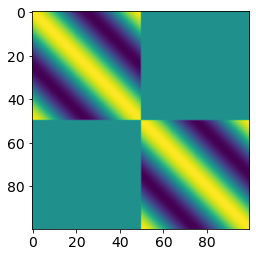

In [176]:
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[:50, :-1] = IN_R1_W * 0.10
    model.fc_x2ah.weight[50:, :-1] = IN_R1_W * 2.0
    model.fc_x2ah.bias[:] = -.2
    model.fc_h2ah.weight[:50, :50] = R1_W * 0.2
    model.fc_h2ah.weight[50:, 50:] = R2_W * 0.2
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref / 180 * np.pi) * 0.0725
plt.imshow(model.fc_h2ah.weight.detach().numpy())

In [177]:
torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")

## Gate blocks info to R1

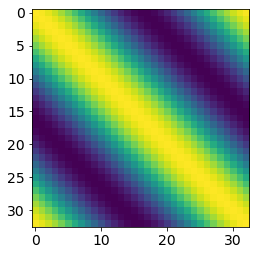

In [365]:
R1_N = 33
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 34
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j])
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 33
DT_pref = torch.arange(DT_N) * 180 / DT_N
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)

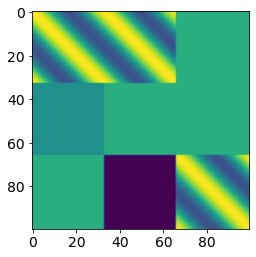

In [366]:
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[R2_i, :-1] = IN_R2_W * 0.3
    model.fc_x2ah.weight[DT_i, :-1] = IN_DT_W * 0.3
    model.fc_x2ah.weight[R1_i, :-1] = IN_R1_W * 0.0
    model.fc_x2ah.bias[:] = -.2
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(R1_i):max(R1_i)+1] = R1_W * 0.3
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(R2_i):max(R2_i)+1] = R2_W * 0.3
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_R1_W * 0.3
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(R1_i):max(R1_i)+1] = (-1) * .1
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(DT_i):max(DT_i)+1] = (-1) * .5
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * R1_pref / 180 * np.pi) * 0.1
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * R1_pref / 180 * np.pi) * 0.1
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref / 180 * np.pi) * 0.1
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref / 180 * np.pi) * 0.1
plt.imshow(model.fc_h2ah.weight.detach().numpy())

In [367]:
torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")

In [204]:
analyze_error(model)

Running the model...


(0.002120490185916424,
 0.0008172711241059005,
 0.997841352887282,
 0.8028722491513431)

## R2 flips DT

In [ ]:
R1_N = 33
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 34
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j])
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 33
DT_pref = torch.arange(DT_N) * 180 / DT_N
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)

## R1 changes tunings a bit    

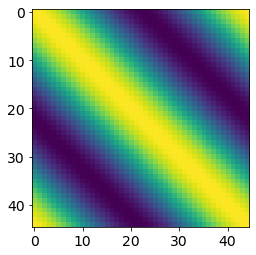

In [353]:
R1_N = 45
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 45
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        c = 0
        if (i*17)%IN_N < IN_N//3: c = -1
        if (i*17)%IN_N > (IN_N*2)//3: c = 1
        c *= 20*0
        
        c = (i*7)%IN_N - IN_N//2
        c *= 4.0
        #c = 0
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j]-c) * 1#(1+ 0*0.1*2*(((i*11)%IN_N)/IN_N-0.5))
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 10
DT_pref = torch.arange(DT_N) * 180 / DT_N
DT_W = torch.zeros(DT_N, DT_N)
for i in range(DT_N):
    for j in range(DT_N):
        DT_W[i, j] = weight(DT_pref[i], DT_pref[j])
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)

In [102]:
fixed_R1_pref=torch.tensor([174., 178.,   2.,   6.,  11.,  15.,  20.,  24.,  29.,  34.,  39.,  43.,
         47.,  51.,  54.,  58.,  61.,  66.,  70.,  73.,  76.,  80.,  83.,  87.,
         91.,  95.,  99., 104., 108., 113., 117., 121., 126., 130., 135., 139.,
        143., 146., 151., 154., 158., 161., 165., 168., 171.])

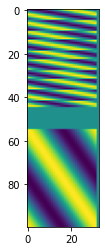

In [103]:
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[R2_i, :-1] = IN_R2_W * 0.3
    model.fc_x2ah.weight[DT_i, :-1] = IN_DT_W * 0.0
    model.fc_x2ah.weight[R1_i, :-1] = IN_R1_W * 0.3
    model.fc_x2ah.bias[:] = -.2
    model.fc_x2ah.bias[DT_i] = .2
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(R1_i):max(R1_i)+1] = R1_W * 0.3
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_W * 0.0
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(R2_i):max(R2_i)+1] = R2_W * 0.3
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_R1_W * 0.0
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(R1_i):max(R1_i)+1] = (-1) * .1 * .1 *.5
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(DT_i):max(DT_i)+1] = (-1) * .5 * 1
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (fixed_R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (fixed_R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref / 180 * np.pi) * 0.0725
plt.imshow(model.fc_h2ah.weight.detach().numpy())
plt.imshow(model.fc_x2ah.weight.detach().numpy())

In [104]:
torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")

## R1 does not change tuning

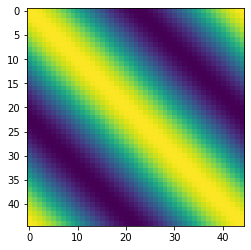

In [255]:
R1_N = 45
R1_pref = torch.arange(R1_N) * 180 / R1_N
R1_W = torch.zeros(R1_N, R1_N)
for i in range(R1_N):
    for j in range(R1_N):
        R1_W[i, j] = weight(R1_pref[i], R1_pref[j])
R2_N = 45
R2_pref = torch.arange(R2_N) * 180 / R2_N
R2_W = torch.zeros(R2_N, R2_N)
for i in range(R2_N):
    for j in range(R2_N):
        R2_W[i, j] = weight(R2_pref[i], R2_pref[j])
IN_N = 32
IN_pref = torch.arange(IN_N) * 180 / IN_N
IN_R1_W = torch.zeros(R1_N, IN_N)
for i in range(R1_N):
    for j in range(IN_N):
        c = 0
        if (i*17)%IN_N < IN_N//3: c = -1
        if (i*17)%IN_N > (IN_N*2)//3: c = 1
        c *= 20*0
        
        c = (i*7)%IN_N - IN_N//2
        c *= 4.0 * 0
        #c = 0
        IN_R1_W[i, j] = weight(R1_pref[i], IN_pref[j]-c) * 1#(1+ 0*0.1*2*(((i*11)%IN_N)/IN_N-0.5))
IN_R2_W = torch.zeros(R2_N, IN_N)
for i in range(R2_N):
    for j in range(IN_N):
        IN_R2_W[i, j] = weight(R2_pref[i], IN_pref[j])
DT_N = 10
DT_pref = torch.arange(DT_N) * 180 / DT_N
DT_W = torch.zeros(DT_N, DT_N)
for i in range(DT_N):
    for j in range(DT_N):
        DT_W[i, j] = weight(DT_pref[i], DT_pref[j])
IN_DT_W = torch.zeros(DT_N, IN_N)
for i in range(DT_N):
    for j in range(IN_N):
        IN_DT_W[i, j] = weight(DT_pref[i], IN_pref[j])
DT_R1_W = torch.zeros(R1_N, DT_N)
for i in range(R1_N):
    for j in range(DT_N):
        DT_R1_W[i, j] = weight(R1_pref[i], DT_pref[j])
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
plt.imshow(R1_W)

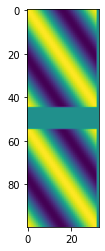

In [262]:
model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
with torch.no_grad():
    model.fc_x2ah.weight[:, :] = 0
    model.fc_x2ah.bias[:] = 0
    model.fc_h2ah.weight[:, :] = 0
    model.fc_h2y.weight[:, :] = 0
    model.fc_h2y.bias[:] = 0
    
    model.fc_x2ah.weight[R2_i, :-1] = IN_R2_W * 0.3
    model.fc_x2ah.weight[DT_i, :-1] = IN_DT_W * 0.0
    model.fc_x2ah.weight[R1_i, :-1] = IN_R1_W * 0.3
    model.fc_x2ah.bias[:] = -.2
    model.fc_x2ah.bias[DT_i] = .2
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(R1_i):max(R1_i)+1] = R1_W * 0.25
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_W * 0.0
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(R2_i):max(R2_i)+1] = R2_W * 0.3
    model.fc_h2ah.weight[min(R1_i):max(R1_i)+1, :][:, min(DT_i):max(DT_i)+1] = DT_R1_W * 0.0
    model.fc_h2ah.weight[min(DT_i):max(DT_i)+1, :][:, min(R1_i):max(R1_i)+1] = (-1) * .1 * .1 *.5
    model.fc_h2ah.weight[min(R2_i):max(R2_i)+1, :][:, min(DT_i):max(DT_i)+1] = (-1) * .5 * 1
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref) / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref / 180 * np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref / 180 * np.pi) * 0.0725
plt.imshow(model.fc_h2ah.weight.detach().numpy())
plt.imshow(model.fc_x2ah.weight.detach().numpy())

## R1 changes tuning, R2 decays

In [354]:
def new_model():
    model = models.CTRNN(task=task, dim_recurrent=dim_recurrent, nonlinearity="retanh")
    with torch.no_grad():
        model.fc_x2ah.weight[:, :] = 0
        model.fc_x2ah.bias[:] = 0
        model.fc_h2ah.weight[:, :] = 0
        model.fc_h2y.weight[:, :] = 0
        model.fc_h2y.bias[:] = 0
    return model
def save_model(model):
    torch.save({'model_state_dict': model.state_dict()}, "data/model_hd.pth")
def put_weights(model, units_from, units_to, units_from_pref=None, units_to_pref=None, weight_fun=weight, m=None, m_s=None):
    if type(units_from) is str: units_from = units_from.upper()
    
    uf_N = orientation_neurons if units_from=="IN" else len(units_from)
    ut_N = len(units_to)
    if m_s is not None: m = m_s / uf_N / ut_N
    if m is None: m = 1
    magnitude = m
    if units_from_pref is None:
        units_from_pref = torch.arange(uf_N) * 180 / uf_N
    if units_to_pref is None:
        units_to_pref = torch.arange(ut_N) * 180 / ut_N
    
    if units_from == "IN":
        units_from = torch.arange(orientation_neurons)
        for i, uf in enumerate(units_from):
            for j, ut in enumerate(units_to):
                with torch.no_grad():
                    model.fc_x2ah.weight[ut, uf] = weight_fun(units_from_pref[i], units_to_pref[j]) * magnitude
    else:
        for i, uf in enumerate(units_from):
            for j, ut in enumerate(units_to):
                with torch.no_grad():
                    model.fc_h2ah.weight[ut, uf] = weight_fun(units_from_pref[i], units_to_pref[j]) * magnitude
def put_bias(model, units_to, m=None, m_s=None):
    ut_N = len(units_to)
    if m_s is not None: m = m_s / 32 / ut_N
    if m is None: m = 1
    magnitude = m
    with torch.no_grad():
        model.fc_x2ah.bias[units_to] = magnitude

In [355]:
R1_N = 45
R2_N = 45
DT_N = 10
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
R1, R2, DT = R1_i, R2_i, DT_i
R1_pref = torch.arange(len(R1))/len(R1)*180
DT_pref = torch.arange(len(DT))/len(DT)*180
R2_pref = torch.arange(len(R2))/len(R2)*180

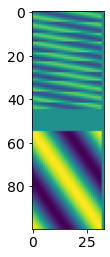

In [356]:
model = new_model()
for j, i in enumerate(R1):
    in_pref_shift = ((j*7)%orientation_neurons - orientation_neurons/2)*4
    in_pref = torch.arange(orientation_neurons)/orientation_neurons * 180 - in_pref_shift
    put_weights(model, "IN", [i], units_from_pref=in_pref, units_to_pref=R1_pref[j:j+1], m=0.16)
#put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R1, R1, m=0.16)
#put_weights(model, DT, DT, m=0.16*R1_N/DT_N)
put_weights(model, R2, R2, m=0.16)

put_weights(model, R1, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=0.09*R1_N/DT_N)

put_bias(model, R1, m=-0.06)
put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref-3)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref-3)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

## R1 changes tuning, R2 gated

In [357]:
R1_N = 45
R2_N = 45
DT_N = 10
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
R1, R2, DT = R1_i, R2_i, DT_i
R1_pref = torch.arange(len(R1))/len(R1)*180
DT_pref = torch.arange(len(DT))/len(DT)*180
R2_pref = torch.arange(len(R2))/len(R2)*180

Running the model...


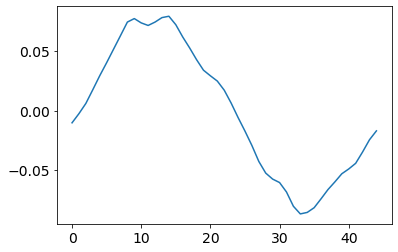

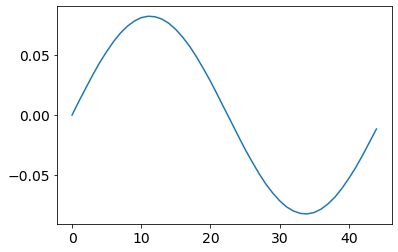

0.04990756884217262
0.04693520441651344
0.09684277325868607
((0.09684277325868607, 0.014615482650697231, 8.922627485780184, 0.40100963472863715), tensor(0.0998, grad_fn=<AddBackward0>), tensor(0.0102, grad_fn=<AddBackward0>))


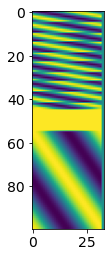

In [358]:
model = new_model()
for j, i in enumerate(R1):
    in_pref_shift = ((j*7)%orientation_neurons - orientation_neurons/2)*4
    in_pref = torch.arange(orientation_neurons)/orientation_neurons * 180 - in_pref_shift
    put_weights(model, "IN", [i], units_from_pref=in_pref, units_to_pref=R1_pref[j:j+1], m=0.3)#16)
#put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R2, m=0.3)
put_weights(model, "IN", DT, m=0.3, weight_fun=weight_ns)

put_weights(model, R1, R1, m=0.16)
#put_weights(model, DT, DT, m=0.16*R1_N/DT_N)
put_weights(model, R2, R2, m=0.16)

put_weights(model, R1, DT, units_to_pref=DT_pref, m=-0.1, weight_fun=weight_ns)
#put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=-0.5, weight_fun=weight_ns)# m=0.15*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1, m=-0.06)
put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref-3)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref-3)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
save_model(model)
print(analyze_error(model, ORI_RES=3))

plt.imshow(model.fc_x2ah.weight.detach().numpy())

In [362]:
import random
random.randint(-60, 60)

41

In [363]:
R1_pref_fixed = torch.tensor([ 18.,  21.,  25.,  28.,  31.,  34.,  38.,  42.,  45.,  50.,  54.,  58.,
         62.,  66.,  71.,  74.,  79.,  83.,  87.,  92.,  96., 101., 105., 108.,
        112., 116., 120., 124., 128., 132., 135., 139., 142., 146., 150., 153.,
        158., 162., 167., 172., 177.,   1.,   5.,  10.,  13.])

Running the model...


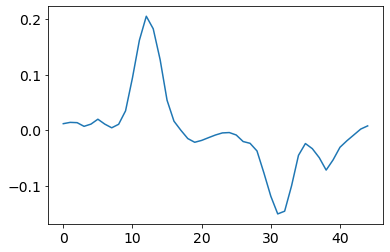

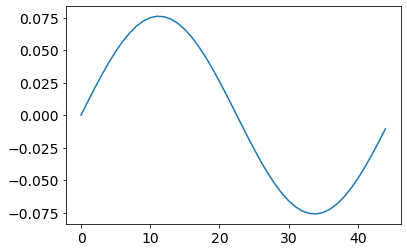

0.17923088371753693
0.10193908214569092
0.28116996586322784
((0.28116992115974426, 0.0022354815155267715, 15.844405843489465, 0.23934596247882528), tensor(0.1090, grad_fn=<AddBackward0>), tensor(0.0100, grad_fn=<AddBackward0>))


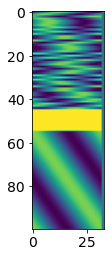

In [364]:
# RANDOM tuning change
model = new_model()
random.seed(1337)
for j, i in enumerate(R1):
    in_pref_shift = random.randint(-70, 70)#((j*7)%orientation_neurons - orientation_neurons/2)*4
    in_pref = torch.arange(orientation_neurons)/orientation_neurons * 180 - in_pref_shift
    put_weights(model, "IN", [i], units_from_pref=in_pref, units_to_pref=R1_pref[j:j+1], m=0.2)#16)
#put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R2, m=0.2)
put_weights(model, "IN", DT, m=0.3, weight_fun=weight_ns)

put_weights(model, R1, R1, m=0.2)
#put_weights(model, DT, DT, m=0.16*R1_N/DT_N)
put_weights(model, R2, R2, m=0.2)

put_weights(model, R1, DT, units_to_pref=DT_pref, m=-0.1, weight_fun=weight_ns)
#put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=-0.5, weight_fun=weight_ns)# m=0.15*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1, m=-0.06)
put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
save_model(model)
print(analyze_error(model))

plt.imshow(model.fc_x2ah.weight.detach().numpy())

## Inversion of tuning

In [205]:
R1a_N = 23
R1b_N = 23
R1_N = R1a_N + R1b_N
R2_N = 44
DT_N = 10
R1a_i = torch.arange(0, R1a_N, dtype=int)
R1b_i = torch.arange(R1a_N, R1a_N+R1b_N, dtype=int)
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
R1a, R1b, R2, DT = R1a_i, R1b_i, R2_i, DT_i
R1a_pref = torch.arange(len(R1a))/len(R1a)*180
R1b_pref = torch.arange(len(R1b))/len(R1b)*180
DT_pref = torch.arange(len(DT))/len(DT)*180
R2_pref = torch.arange(len(R2))/len(R2)*180

In [206]:
R1_pref_fixed = torch.tensor([  0.,   8.,  15.,  23.,  31.,  39.,  47.,  55.,  62.,  70.,  78.,  85.,
         94., 102., 109., 117., 125., 133., 141., 148., 156., 164., 173.,  90.,
         98., 106., 113., 120., 129., 137., 145., 151., 159., 168., 177.,   5.,
         11.,  19.,  27.,  35.,  43.,  51.,  59.,  66.,  74.,  81.])

Running the model...
(0.07855828106403351, 0.1738216131925583, 8.09953755130019, 7.9453761155424)


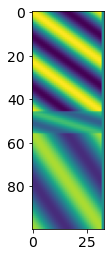

In [208]:
model = new_model()
put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R1a, m=0.4)
put_weights(model, "IN", R1b, m=0.4)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)

put_weights(model, R1a, R1a, m=0.15)
put_weights(model, R1b, R1b, m=0.15)
put_weights(model, R1a, R1b, m=-0.2)
put_weights(model, R1b, R1a, m=-0.15)

put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=0.09*R1_N/DT_N)

put_bias(model, R1a, m=-0.06)
put_bias(model, R1b, m=-0.06)
#put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.06)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
save_model(model)
print(analyze_error(model))

plt.imshow(model.fc_x2ah.weight.detach().numpy())

## Inversion of tuning, O1

In [215]:
R1a_N = 23
R1b_N = 23
R1_N = R1a_N + R1b_N
R2_N = 44
DT_N = 10
R1a_i = torch.arange(0, R1a_N, dtype=int)
R1b_i = torch.arange(R1a_N, R1a_N+R1b_N, dtype=int)
R1_i = torch.arange(0, R1_N, dtype=int)
DT_i = torch.arange(R1_N, R1_N+DT_N, dtype=int)
R2_i = torch.arange(R1_N+DT_N, R1_N+DT_N+R2_N, dtype=int)
R1a, R1b, R2, DT = R1a_i, R1b_i, R2_i, DT_i
R1a_pref = torch.arange(len(R1a))/len(R1a)*180
R1b_pref = torch.arange(len(R1b))/len(R1b)*180
DT_pref = torch.arange(len(DT))/len(DT)*180
R2_pref = torch.arange(len(R2))/len(R2)*180

In [216]:
R1_pref_fixed = torch.tensor([  1.,   8.,  16.,  23.,  32.,  40.,  47.,  55.,  63.,  70.,  78.,  86.,
         94., 102., 110., 117., 125., 134., 140., 149., 156., 164., 172.,  90.,
         98., 106., 114., 121., 130., 137., 145., 153., 161., 168., 177.,   4.,
         12.,  19.,  28.,  35.,  43.,  51.,  59.,  66.,  74.,  81.])

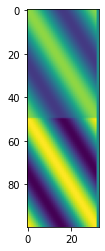

In [60]:
model = new_model()
put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R1a, m=0.2)
put_weights(model, "IN", R1b, m=0.3)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)

put_weights(model, R1a, R1a, m=0.2)
put_weights(model, R1b, R1b, m=0.2)
put_weights(model, R1a, R1b, m=-0.18)
put_weights(model, R1b, R1a, m=-0.1)

put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=0.09*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1a, m=-0.1)
put_bias(model, R1b, m=-0.1)
#put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.06)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725/2.5
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725/2.5
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725/2.5/0.9
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725/2.5/0.9
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

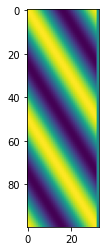

In [72]:
model = new_model()
put_weights(model, "IN", DT, m=0.16)
put_weights(model, "IN", R1a, m=0.3)
put_weights(model, "IN", R1b, m=0.3)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)

put_weights(model, R1a, R1a, m=0.17)
put_weights(model, R1b, R1b, m=0.15)
put_weights(model, R1a, R1b, m=-0.22)
put_weights(model, R1b, R1a, m=-0.15)

put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=0.09*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1a, m=-0.095)
put_bias(model, R1b, m=-0.13)
#put_bias(model, DT, m=-0.26)
put_bias(model, R2, m=-0.06)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725/2.5/0.9
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725/2.5/0.9
save_model(model)

plt.imshow(model.fc_x2ah.weight.detach().numpy())

Running the model...
(0.020821131765842438, 0.3631640672683716, 4.056111638746715, nan)


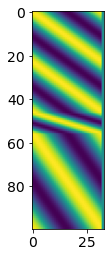

In [217]:
model = new_model()
put_weights(model, "IN", DT, m=0.3)#, weight_fun=weight_ns)
put_weights(model, "IN", R1a, m=0.3)
put_weights(model, "IN", R1b, m=0.3)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)
#put_weights(model, DT, DT, m=0.16)

put_weights(model, R1a, R1a, m=0.15*1.7)
put_weights(model, R1b, R1b, m=0.15*1.7)
put_weights(model, R1a, R1b, m=-0.2*2)
put_weights(model, R1b, R1a, m=-0.1*2)

#put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.3)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.08, weight_fun=weight_ns)
#put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=-0.5, weight_fun=weight_ns)# m=0.15*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1a, m=-0.1)
put_bias(model, R1b, m=-0.1)
put_bias(model, DT, m=-0.1)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725 * 1.1 
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725 * 1.1
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
save_model(model)
print(analyze_error(model))

plt.imshow(model.fc_x2ah.weight.detach().numpy())

Running the model...
(0.02075609378516674, 0.004494695924222469, 4.0495605983907765, 0.2820343894466751)


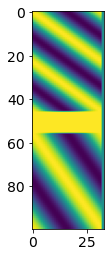

In [220]:
model = new_model()
put_weights(model, "IN", DT, m=0.3, weight_fun=weight_ns)
put_weights(model, "IN", R1a, m=0.3)
put_weights(model, "IN", R1b, m=0.3)
put_weights(model, "IN", R2, m=0.3)

put_weights(model, R2, R2, m=0.16)
#put_weights(model, DT, DT, m=0.16)

put_weights(model, R1a, R1a, m=0.15*1.7)
put_weights(model, R1b, R1b, m=0.15*1.7)
put_weights(model, R1a, R1b, m=-0.2*2)
put_weights(model, R1b, R1a, m=-0.1*2)

#put_weights(model, R1a, DT, units_to_pref=DT_pref, m=-0.3)
put_weights(model, R1b, DT, units_to_pref=DT_pref, m=-0.15, weight_fun=weight_ns)
#put_weights(model, R2, DT, units_to_pref=DT_pref, m=-0.16/4)
put_weights(model, DT, R2, m=-0.5, weight_fun=weight_ns)# m=0.15*R1_N/DT_N if DT_N>0 else 0)

put_bias(model, R1a, m=-0.1)
put_bias(model, R1b, m=-0.1)
#put_bias(model, DT, m=-0.1)
put_bias(model, R2, m=-0.1)

with torch.no_grad():
    model.fc_h2y.weight[1, R1a_i] = torch.cos(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1a_i] = torch.sin(2 * (R1a_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[1, R1b_i] = torch.cos(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1b_i] = torch.sin(2 * (-R1b_pref)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[3, R2_i] = torch.cos(2 * R2_pref/180 *np.pi) * 0.0725 * 1.1 
    model.fc_h2y.weight[2, R2_i] = torch.sin(2 * R2_pref/180 *np.pi) * 0.0725 * 1.1
    
    model.fc_h2y.weight[1, R1_i] = torch.cos(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
    model.fc_h2y.weight[0, R1_i] = torch.sin(2 * (R1_pref_fixed)/180 *np.pi) * 0.0725
save_model(model)
print(analyze_error(model, ORI_RES=3))

plt.imshow(model.fc_x2ah.weight.detach().numpy())